In [23]:
import pandas as pd

india = pd.read_csv('india_clean.csv')
jordan = pd.read_csv('jordan_clean.csv')
florida = pd.read_csv('florida_clean.csv')
california = pd.read_csv('california_clean.csv')

In [24]:
# Clip LOS in all datasets to ensure minimum 1 day
for df in [india, jordan, florida, california]:
    if "los" in df.columns:
        df["los"] = df["los"].clip(lower=1)


In [25]:
# Re-import necessary libraries after state reset
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.utils import compute_sample_weight
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from sksurv.metrics import concordance_index_censored
from scipy.stats import wilcoxon

# Map dataset names to their dataframes
dataset_registry = {
    "India": india,
    "Jordan": jordan,
    "Florida": florida,
    "California": california
}

# Choose source and target
source_name = "California" #
target_name = "India" # Florida, California
source_df = dataset_registry[source_name]
target_df = dataset_registry[target_name]
# Filter out invalid LOS values (<= 0)
source_df = source_df[source_df["los"] > 0].copy()
target_df = target_df[target_df["los"] > 0].copy()

# Convert to sksurv format
def to_sksurv_y(df):
    return np.array([(bool(e), t) for e, t in zip(df['event'], df['los'])],
                    dtype=[('event', bool), ('time', float)])

def to_X(df):
    return df[['age', 'sex', 'gcs']].values

X_source = to_X(source_df)
y_source = to_sksurv_y(source_df)
X_target = to_X(target_df)
y_target = to_sksurv_y(target_df)


In [26]:

# Direct Transfer: Train on source, test on target using 5-fold CV
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cindices_direct = []
for train_idx, test_idx in kf.split(X_target):
    model = GradientBoostingSurvivalAnalysis(n_estimators=150, random_state=0)
    model.fit(X_source, y_source)
    preds = model.predict(X_target[test_idx])
    cindex = concordance_index_censored(y_target['event'][test_idx], y_target['time'][test_idx], preds)[0]
    cindices_direct.append(cindex)

# Standard Fine-Tuning
cindices_standard = []
for train_idx, test_idx in kf.split(X_target):
    model = GradientBoostingSurvivalAnalysis(n_estimators=100, warm_start=True, random_state=0)
    model.fit(X_source, y_source)
    model.set_params(n_estimators=150)
    model.fit(X_target[train_idx], y_target[train_idx])
    preds = model.predict(X_target[test_idx])
    cindex = concordance_index_censored(y_target['event'][test_idx], y_target['time'][test_idx], preds)[0]
    cindices_standard.append(cindex)

# Weighted Fine-Tuning
cindices_weighted = []
for train_idx, test_idx in kf.split(X_target):
    model = GradientBoostingSurvivalAnalysis(n_estimators=100, warm_start=True, random_state=0)
    model.fit(X_source, y_source)
    model.set_params(n_estimators=150)
    weights = compute_sample_weight(class_weight={1: 5, 0: 1}, y=y_target['event'][train_idx].astype(int))
    model.fit(X_target[train_idx], y_target[train_idx], sample_weight=weights)
    preds = model.predict(X_target[test_idx])
    cindex = concordance_index_censored(y_target['event'][test_idx], y_target['time'][test_idx], preds)[0]
    cindices_weighted.append(cindex)

# Comparison
def compare_models(cindex_a, cindex_b, name_a="Model A", name_b="Model B"):
    stat, p = wilcoxon(cindex_a, cindex_b)
    mean_diff = np.mean(np.array(cindex_b) - np.array(cindex_a))
    return {
        "Model A": name_a,
        "Model B": name_b,
        "Mean Diff": mean_diff,
        "p-value": p,
        "Significant": p < 0.05
    }

comparison_results = [
    compare_models(cindices_direct, cindices_standard, "Direct Transfer", "Standard Fine-Tuning"),
    compare_models(cindices_direct, cindices_weighted, "Direct Transfer", "Weighted Fine-Tuning"),
    compare_models(cindices_standard, cindices_weighted, "Standard Fine-Tuning", "Weighted Fine-Tuning"),
]

comparison_df = pd.DataFrame(comparison_results)
comparison_df


,Model A,Model B,Mean Diff,p-value,Significant
0,Direct Transfer,Standard Fine-Tuning,0.036421,0.0625,False
1,Direct Transfer,Weighted Fine-Tuning,0.032779,0.0625,False
2,Standard Fine-Tuning,Weighted Fine-Tuning,-0.003642,0.1250,False


In [27]:
print(f"\n📊 Summary Stats:")
print(f"Direct Transfer       → Mean: {np.mean(cindices_direct):.3f}, SD: {np.std(cindices_direct):.3f}")
print(f"Standard Fine-Tuning  → Mean: {np.mean(cindices_standard):.3f}, SD: {np.std(cindices_standard):.3f}")
print(f"Weighted Fine-Tuning  → Mean: {np.mean(cindices_weighted):.3f}, SD: {np.std(cindices_weighted):.3f}")



📊 Summary Stats:
Direct Transfer       → Mean: 0.725, SD: 0.014
Standard Fine-Tuning  → Mean: 0.761, SD: 0.011
Weighted Fine-Tuning  → Mean: 0.757, SD: 0.012


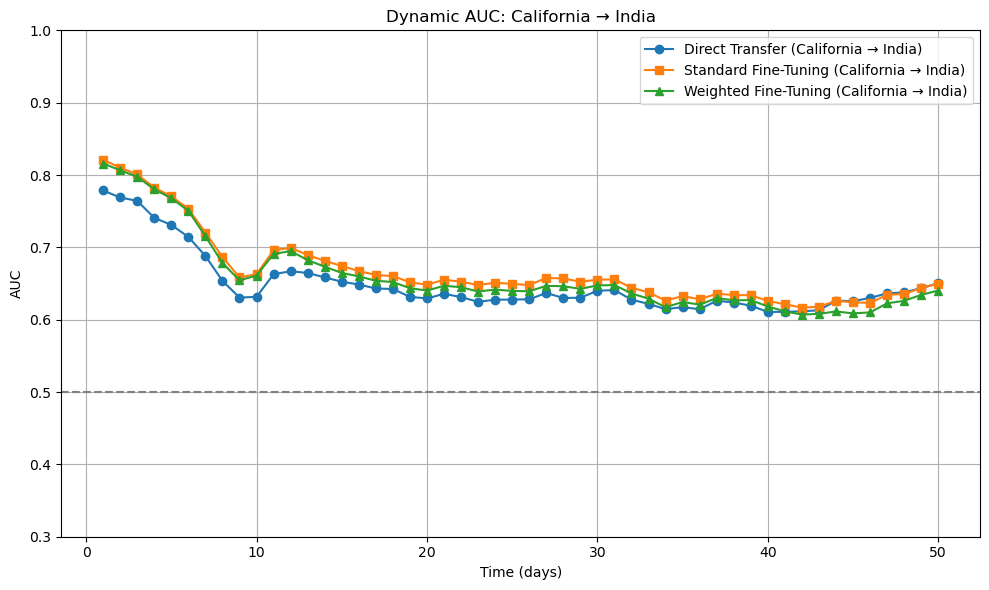

In [29]:
from sksurv.metrics import cumulative_dynamic_auc
import matplotlib.pyplot as plt
import numpy as np

# Choose fixed time points (adjust as needed)
time_points = np.arange(1, 51)

# Train each model on full data for source→target
model_direct = GradientBoostingSurvivalAnalysis(n_estimators=150, random_state=0)
model_direct.fit(X_source, y_source)
pred_direct = model_direct.predict(X_target)

model_standard = GradientBoostingSurvivalAnalysis(n_estimators=100, warm_start=True, random_state=0)
model_standard.fit(X_source, y_source)
model_standard.set_params(n_estimators=150)
model_standard.fit(X_target, y_target)
pred_standard = model_standard.predict(X_target)

model_weighted = GradientBoostingSurvivalAnalysis(n_estimators=100, warm_start=True, random_state=0)
model_weighted.fit(X_source, y_source)
model_weighted.set_params(n_estimators=150)
sample_weight_all = compute_sample_weight(class_weight={1: 5, 0: 1}, y=y_target['event'].astype(int))
model_weighted.fit(X_target, y_target, sample_weight=sample_weight_all)
pred_weighted = model_weighted.predict(X_target)

# Compute dynamic AUC
def compute_dynamic_auc(y_train, y_test, risk_scores, time_points):
    aucs = []
    for t in time_points:
        _, auc = cumulative_dynamic_auc(y_train, y_test, risk_scores, times=t)
        aucs.append(auc)
    return np.array(aucs)

auc_direct = compute_dynamic_auc(y_target, y_target, pred_direct, time_points)
auc_standard = compute_dynamic_auc(y_target, y_target, pred_standard, time_points)
auc_weighted = compute_dynamic_auc(y_target, y_target, pred_weighted, time_points)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(time_points, auc_direct, label=f'Direct Transfer ({source_name} → {target_name})', marker='o')
plt.plot(time_points, auc_standard, label=f'Standard Fine-Tuning ({source_name} → {target_name})', marker='s')
plt.plot(time_points, auc_weighted, label=f'Weighted Fine-Tuning ({source_name} → {target_name})', marker='^')

plt.axhline(0.5, ls='--', color='gray')
plt.title(f'Dynamic AUC: {source_name} → {target_name}')
plt.xlabel('Time (days)')
plt.ylabel('AUC')
plt.ylim(0.3, 1.0)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [30]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sksurv.ensemble import GradientBoostingSurvivalAnalysis, RandomSurvivalForest
from sksurv.metrics import concordance_index_censored

# Few-shot training ratios
ratios = [0.05, 0.10, 0.25, 0.50, 0.75, 0.90]
results = []

# Convert target dataset to X/y (if not already)
X_target = to_X(target_df)  # same function as used earlier
y_target = to_sksurv_y(target_df)

# Split once for consistency
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X_target, y_target, test_size=0.2, random_state=42
)

# Function to evaluate one model on one ratio
def evaluate_model(model_class, X_train, y_train, model_name, ratio):
    model = model_class(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    cindex = concordance_index_censored(y_test["event"], y_test["time"], preds)[0]
    return {"Model": model_name, "Train_Ratio": ratio, "C-Index": cindex}

# Evaluate each ratio for both models
for ratio in ratios:
    X_sub, _, y_sub, _ = train_test_split(X_train_full, y_train_full, train_size=ratio, random_state=42)
    results.append(evaluate_model(GradientBoostingSurvivalAnalysis, X_sub, y_sub, "GradientBoosting", ratio))
    results.append(evaluate_model(RandomSurvivalForest, X_sub, y_sub, "RandomSurvivalForest", ratio))

# Results DataFrame
fewshot_df = pd.DataFrame(results)
print(fewshot_df)


                   Model  Train_Ratio   C-Index
0       GradientBoosting         0.05  0.748962
1   RandomSurvivalForest         0.05  0.734595
2       GradientBoosting         0.10  0.775092
3   RandomSurvivalForest         0.10  0.756432
4       GradientBoosting         0.25  0.792922
5   RandomSurvivalForest         0.25  0.767673
6       GradientBoosting         0.50  0.792779
7   RandomSurvivalForest         0.50  0.765843
8       GradientBoosting         0.75  0.794879
9   RandomSurvivalForest         0.75  0.765616
10      GradientBoosting         0.90  0.792707
11  RandomSurvivalForest         0.90  0.768362


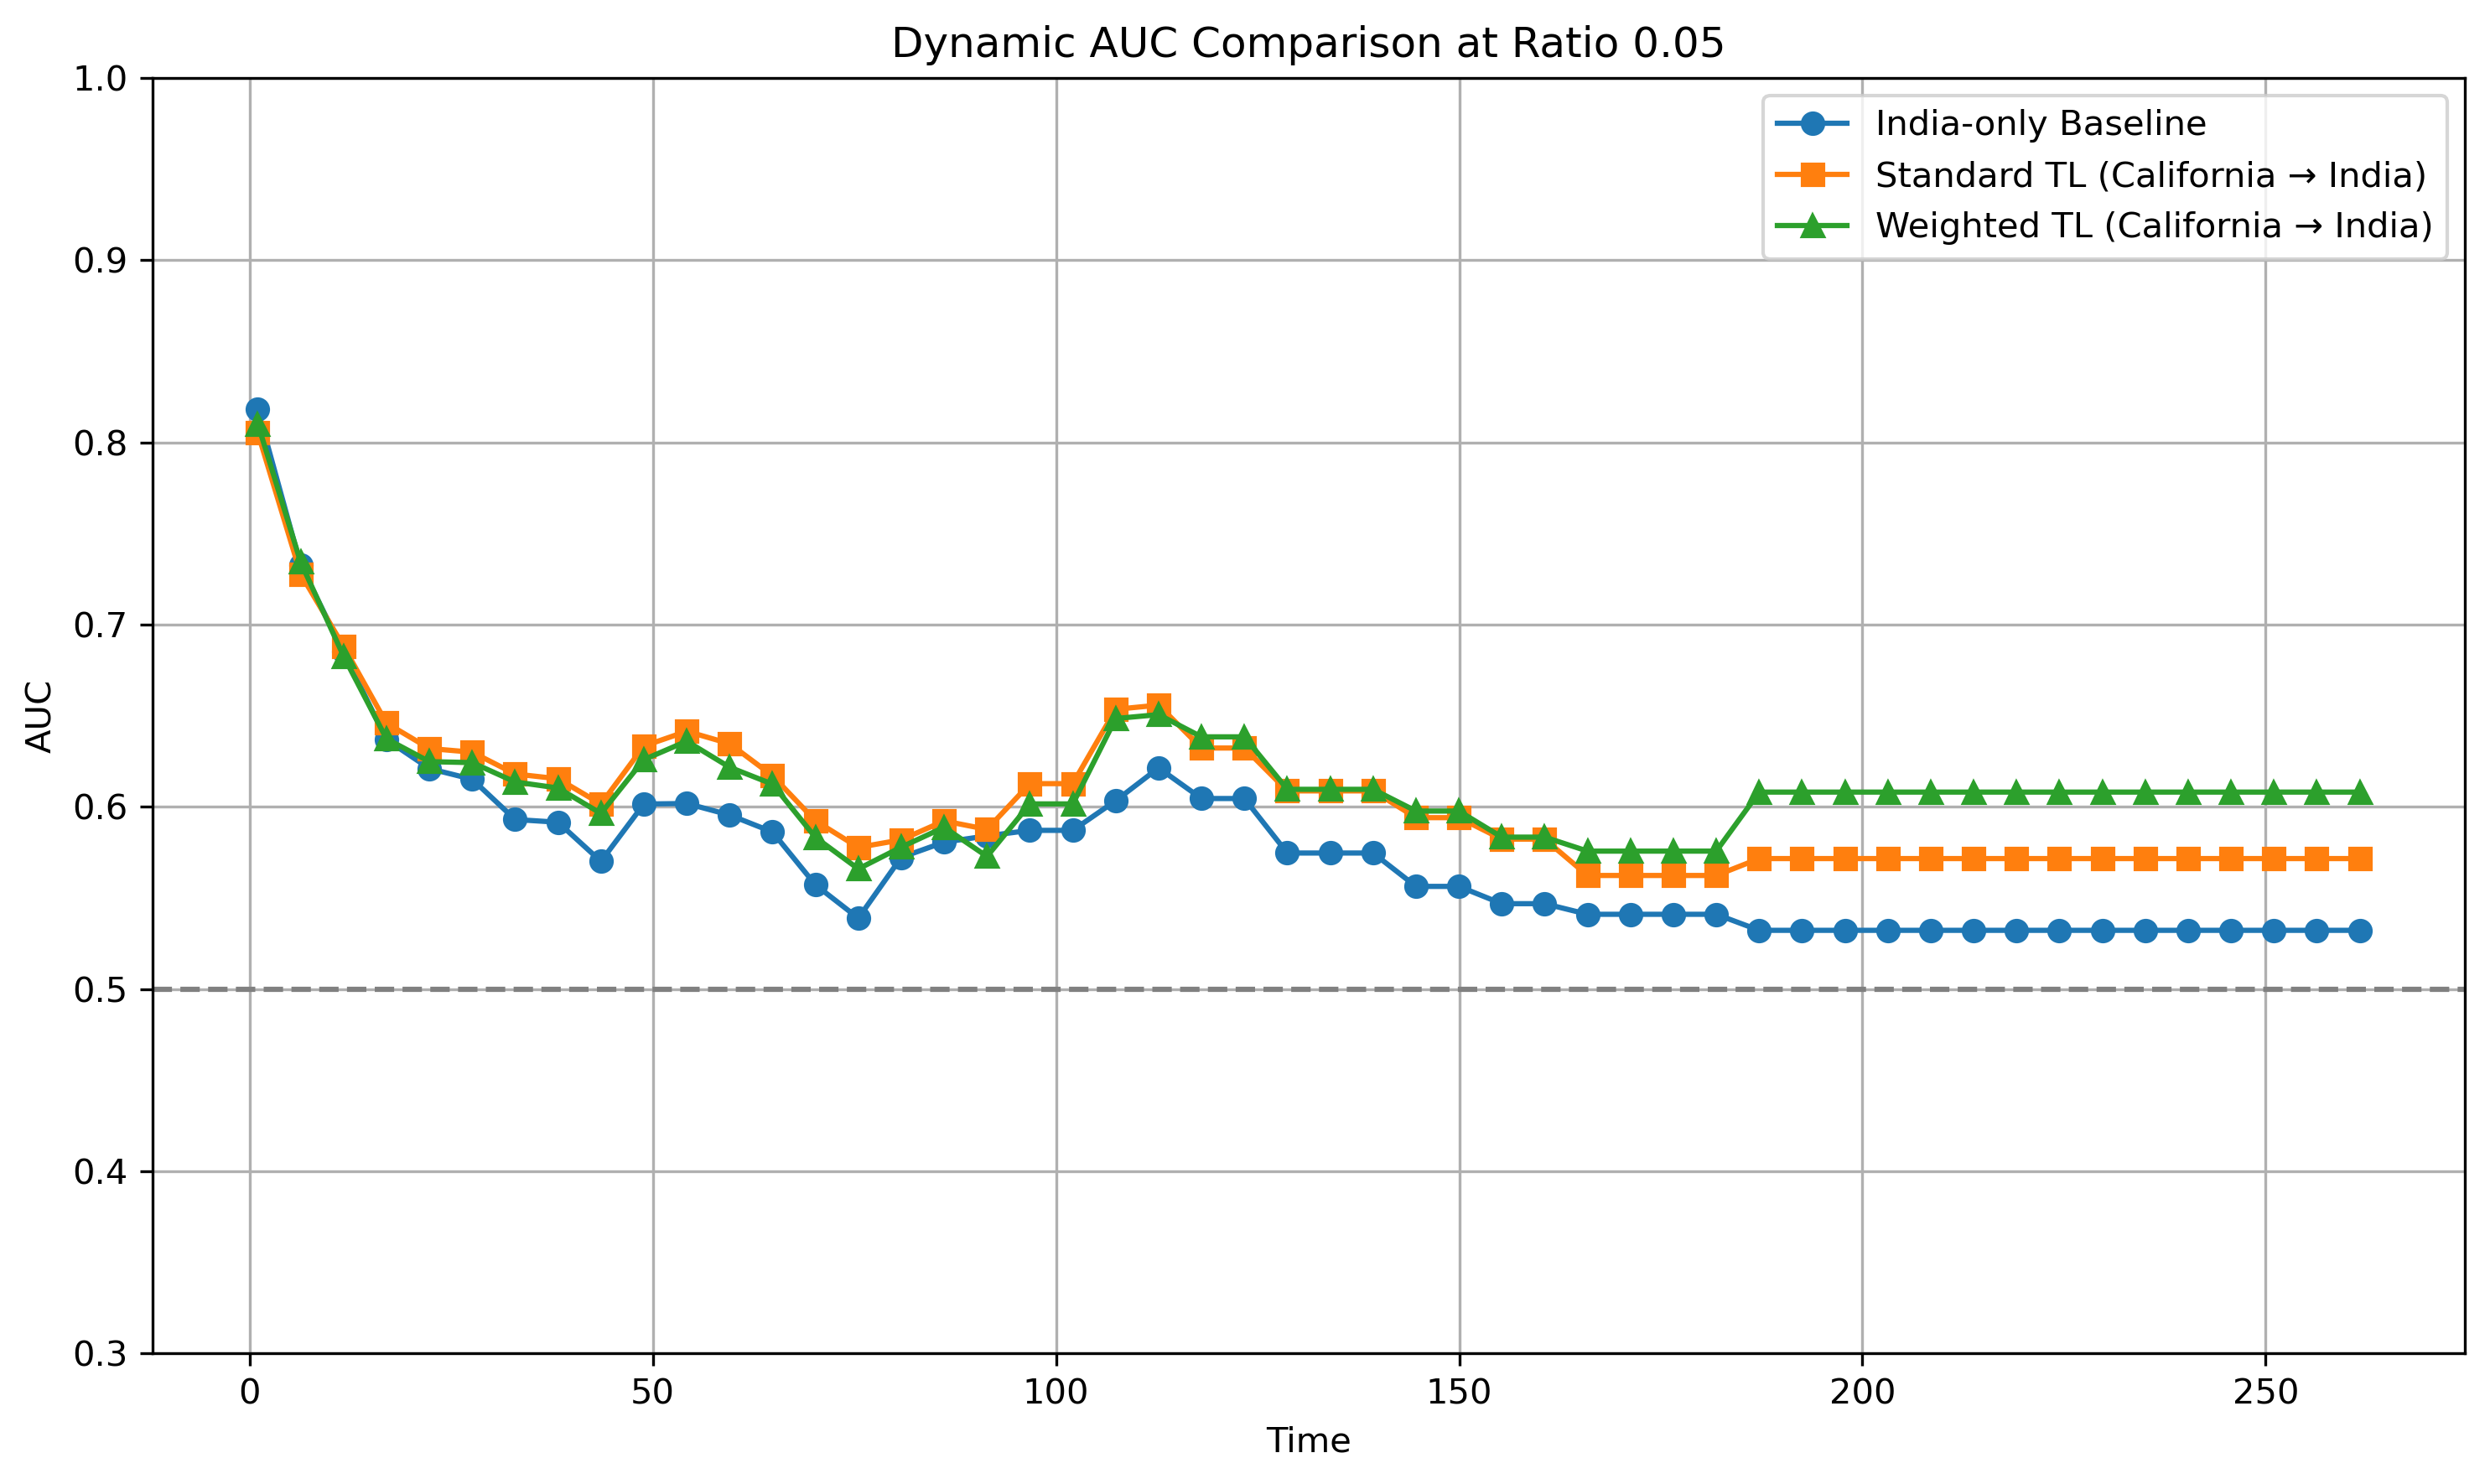

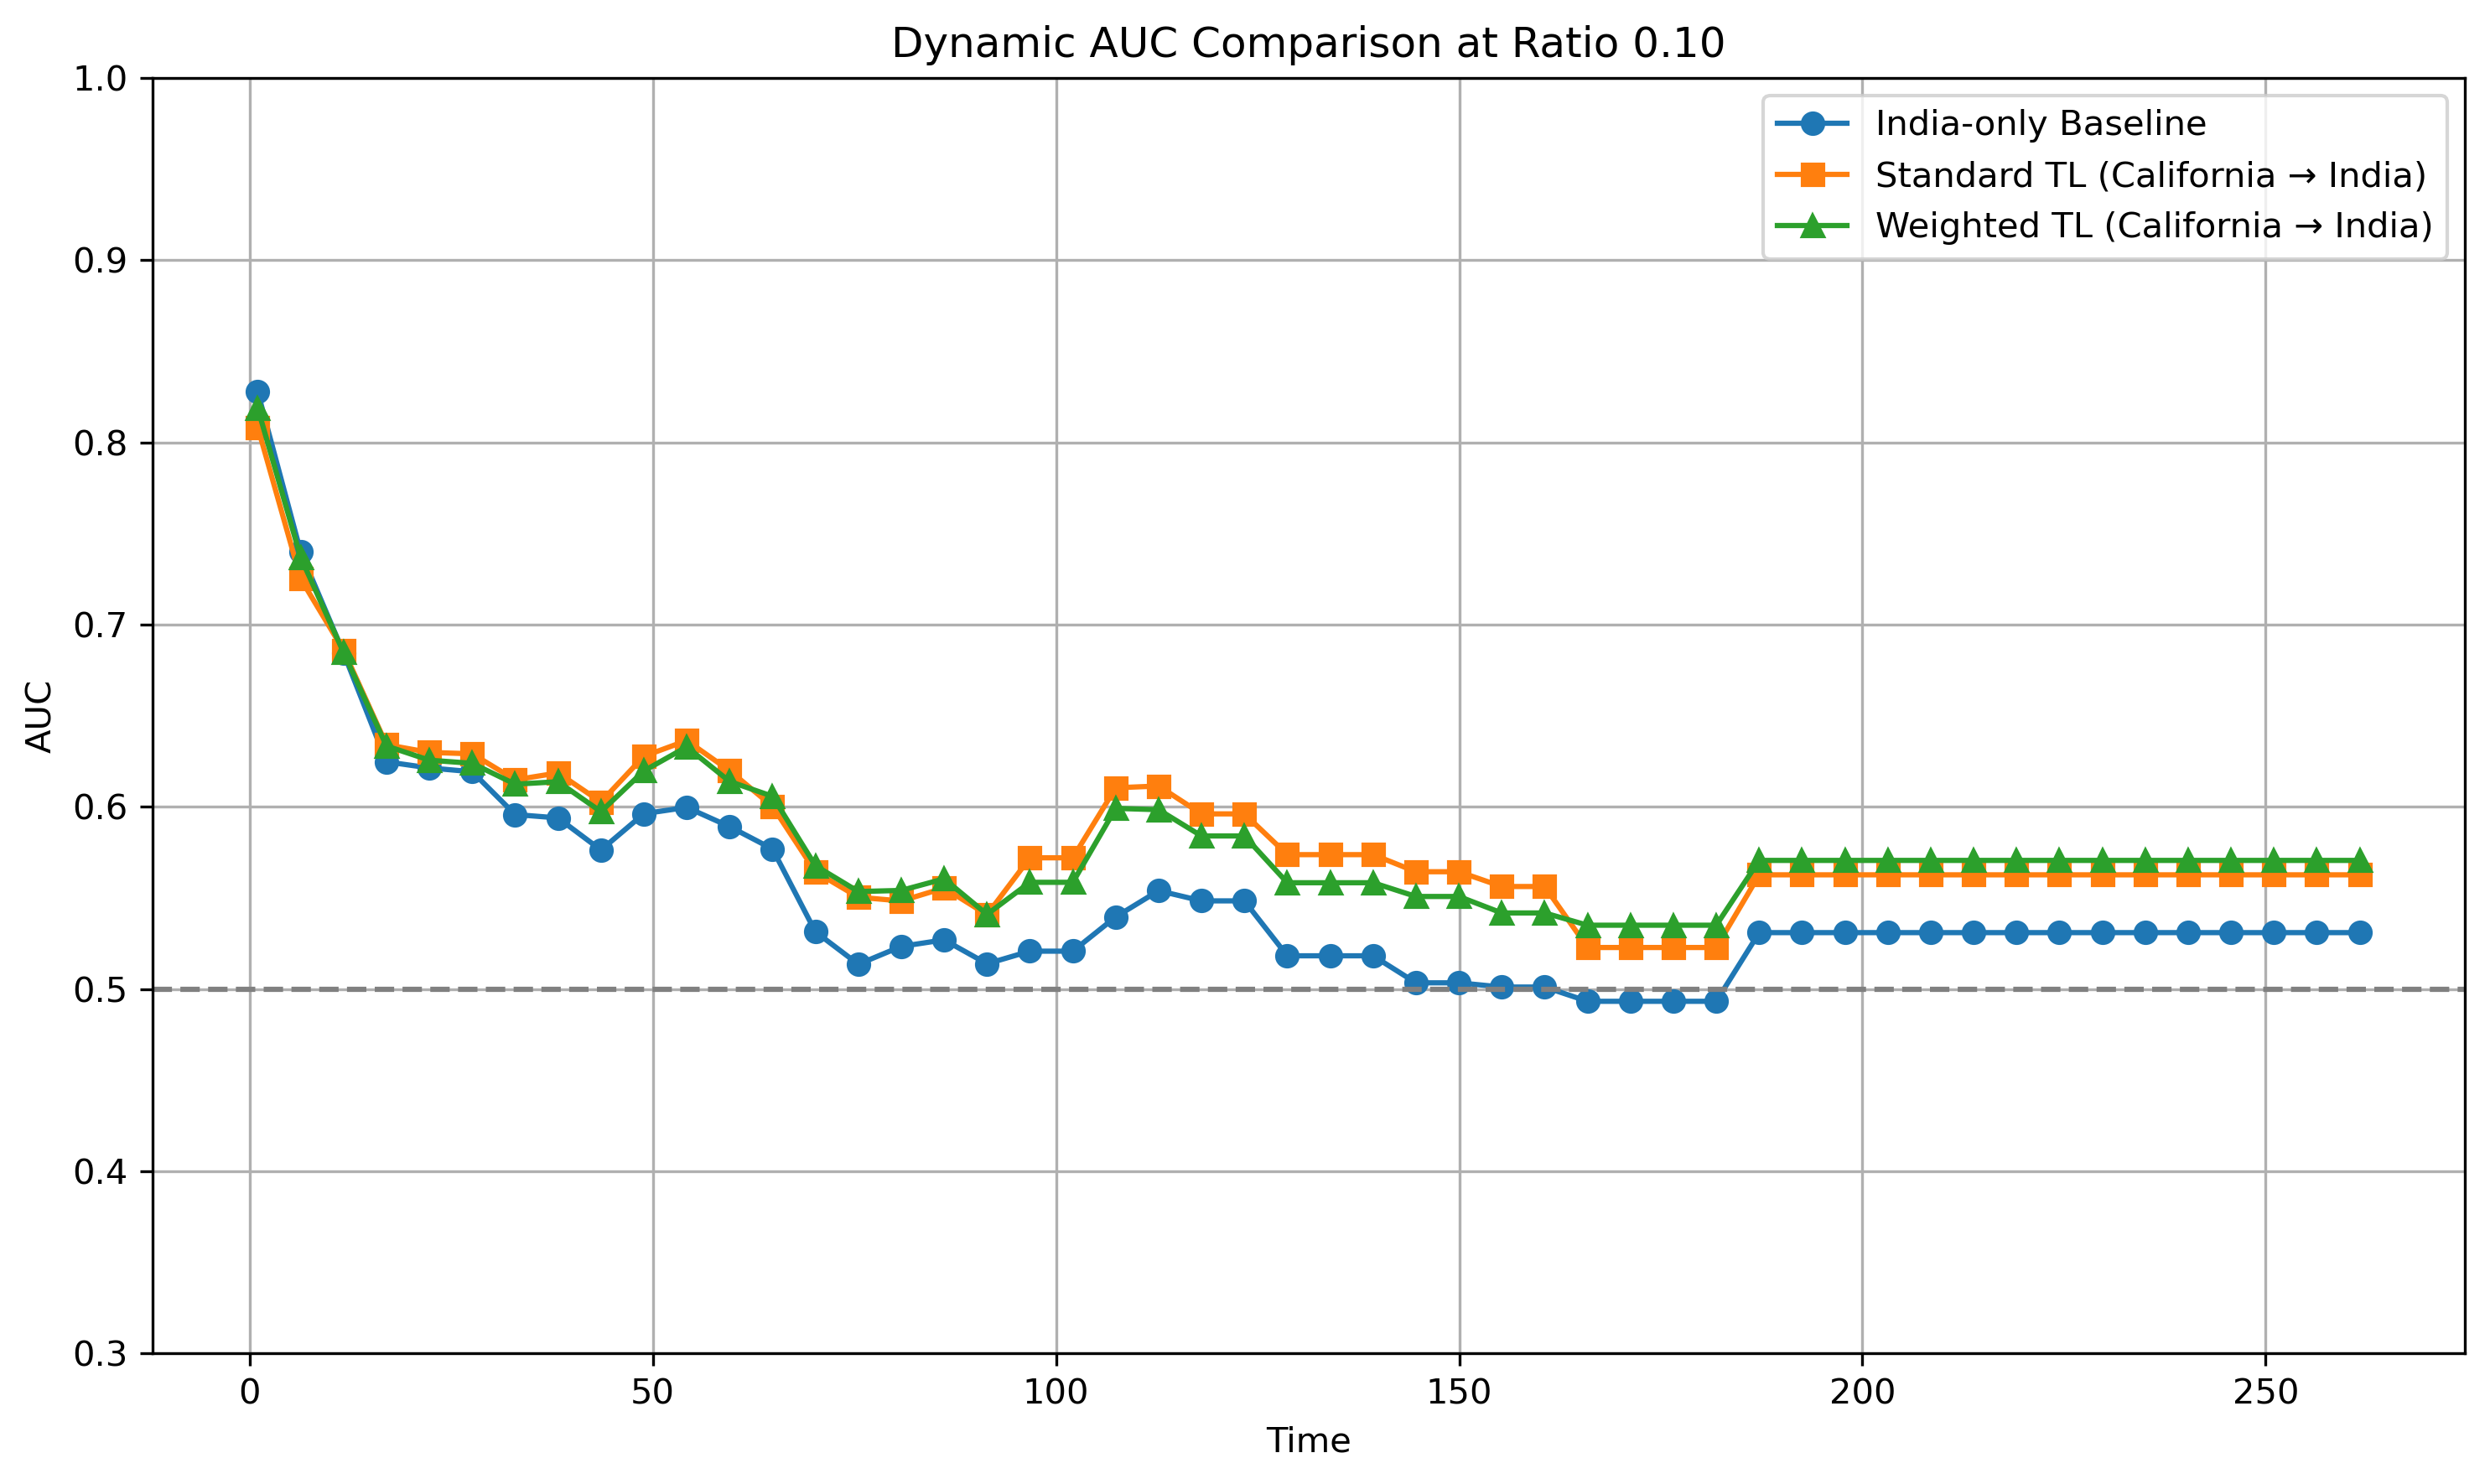

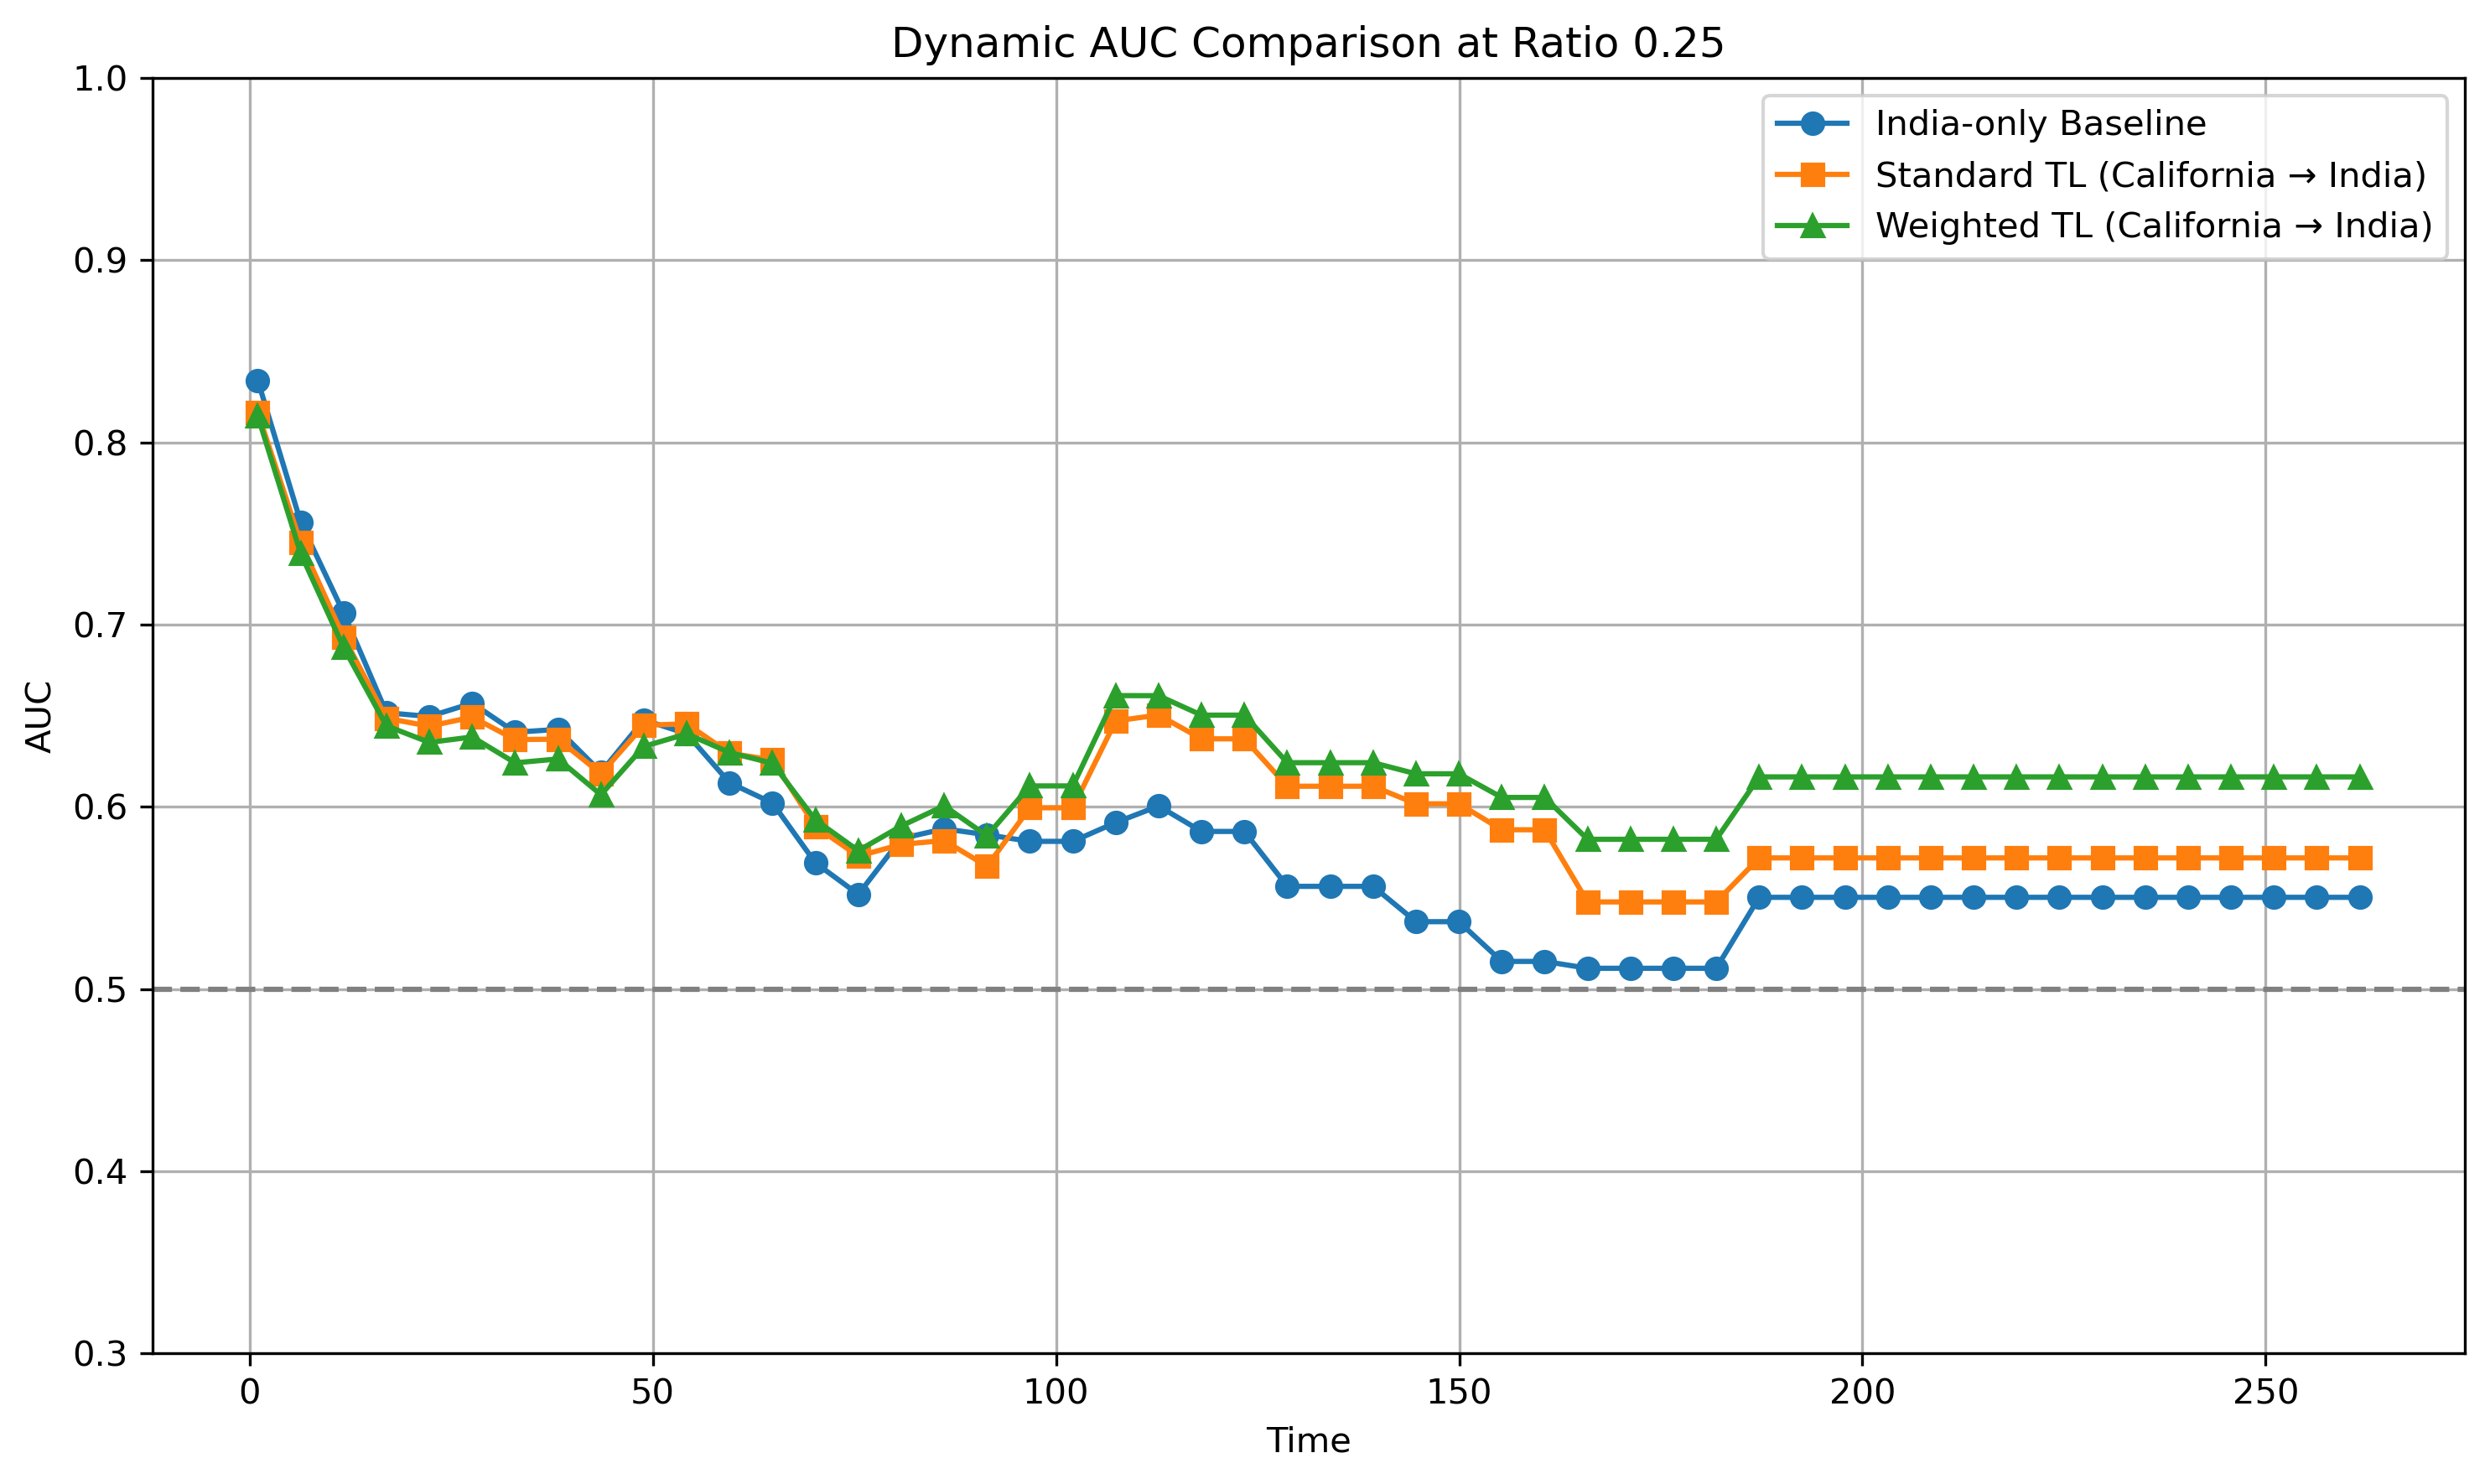

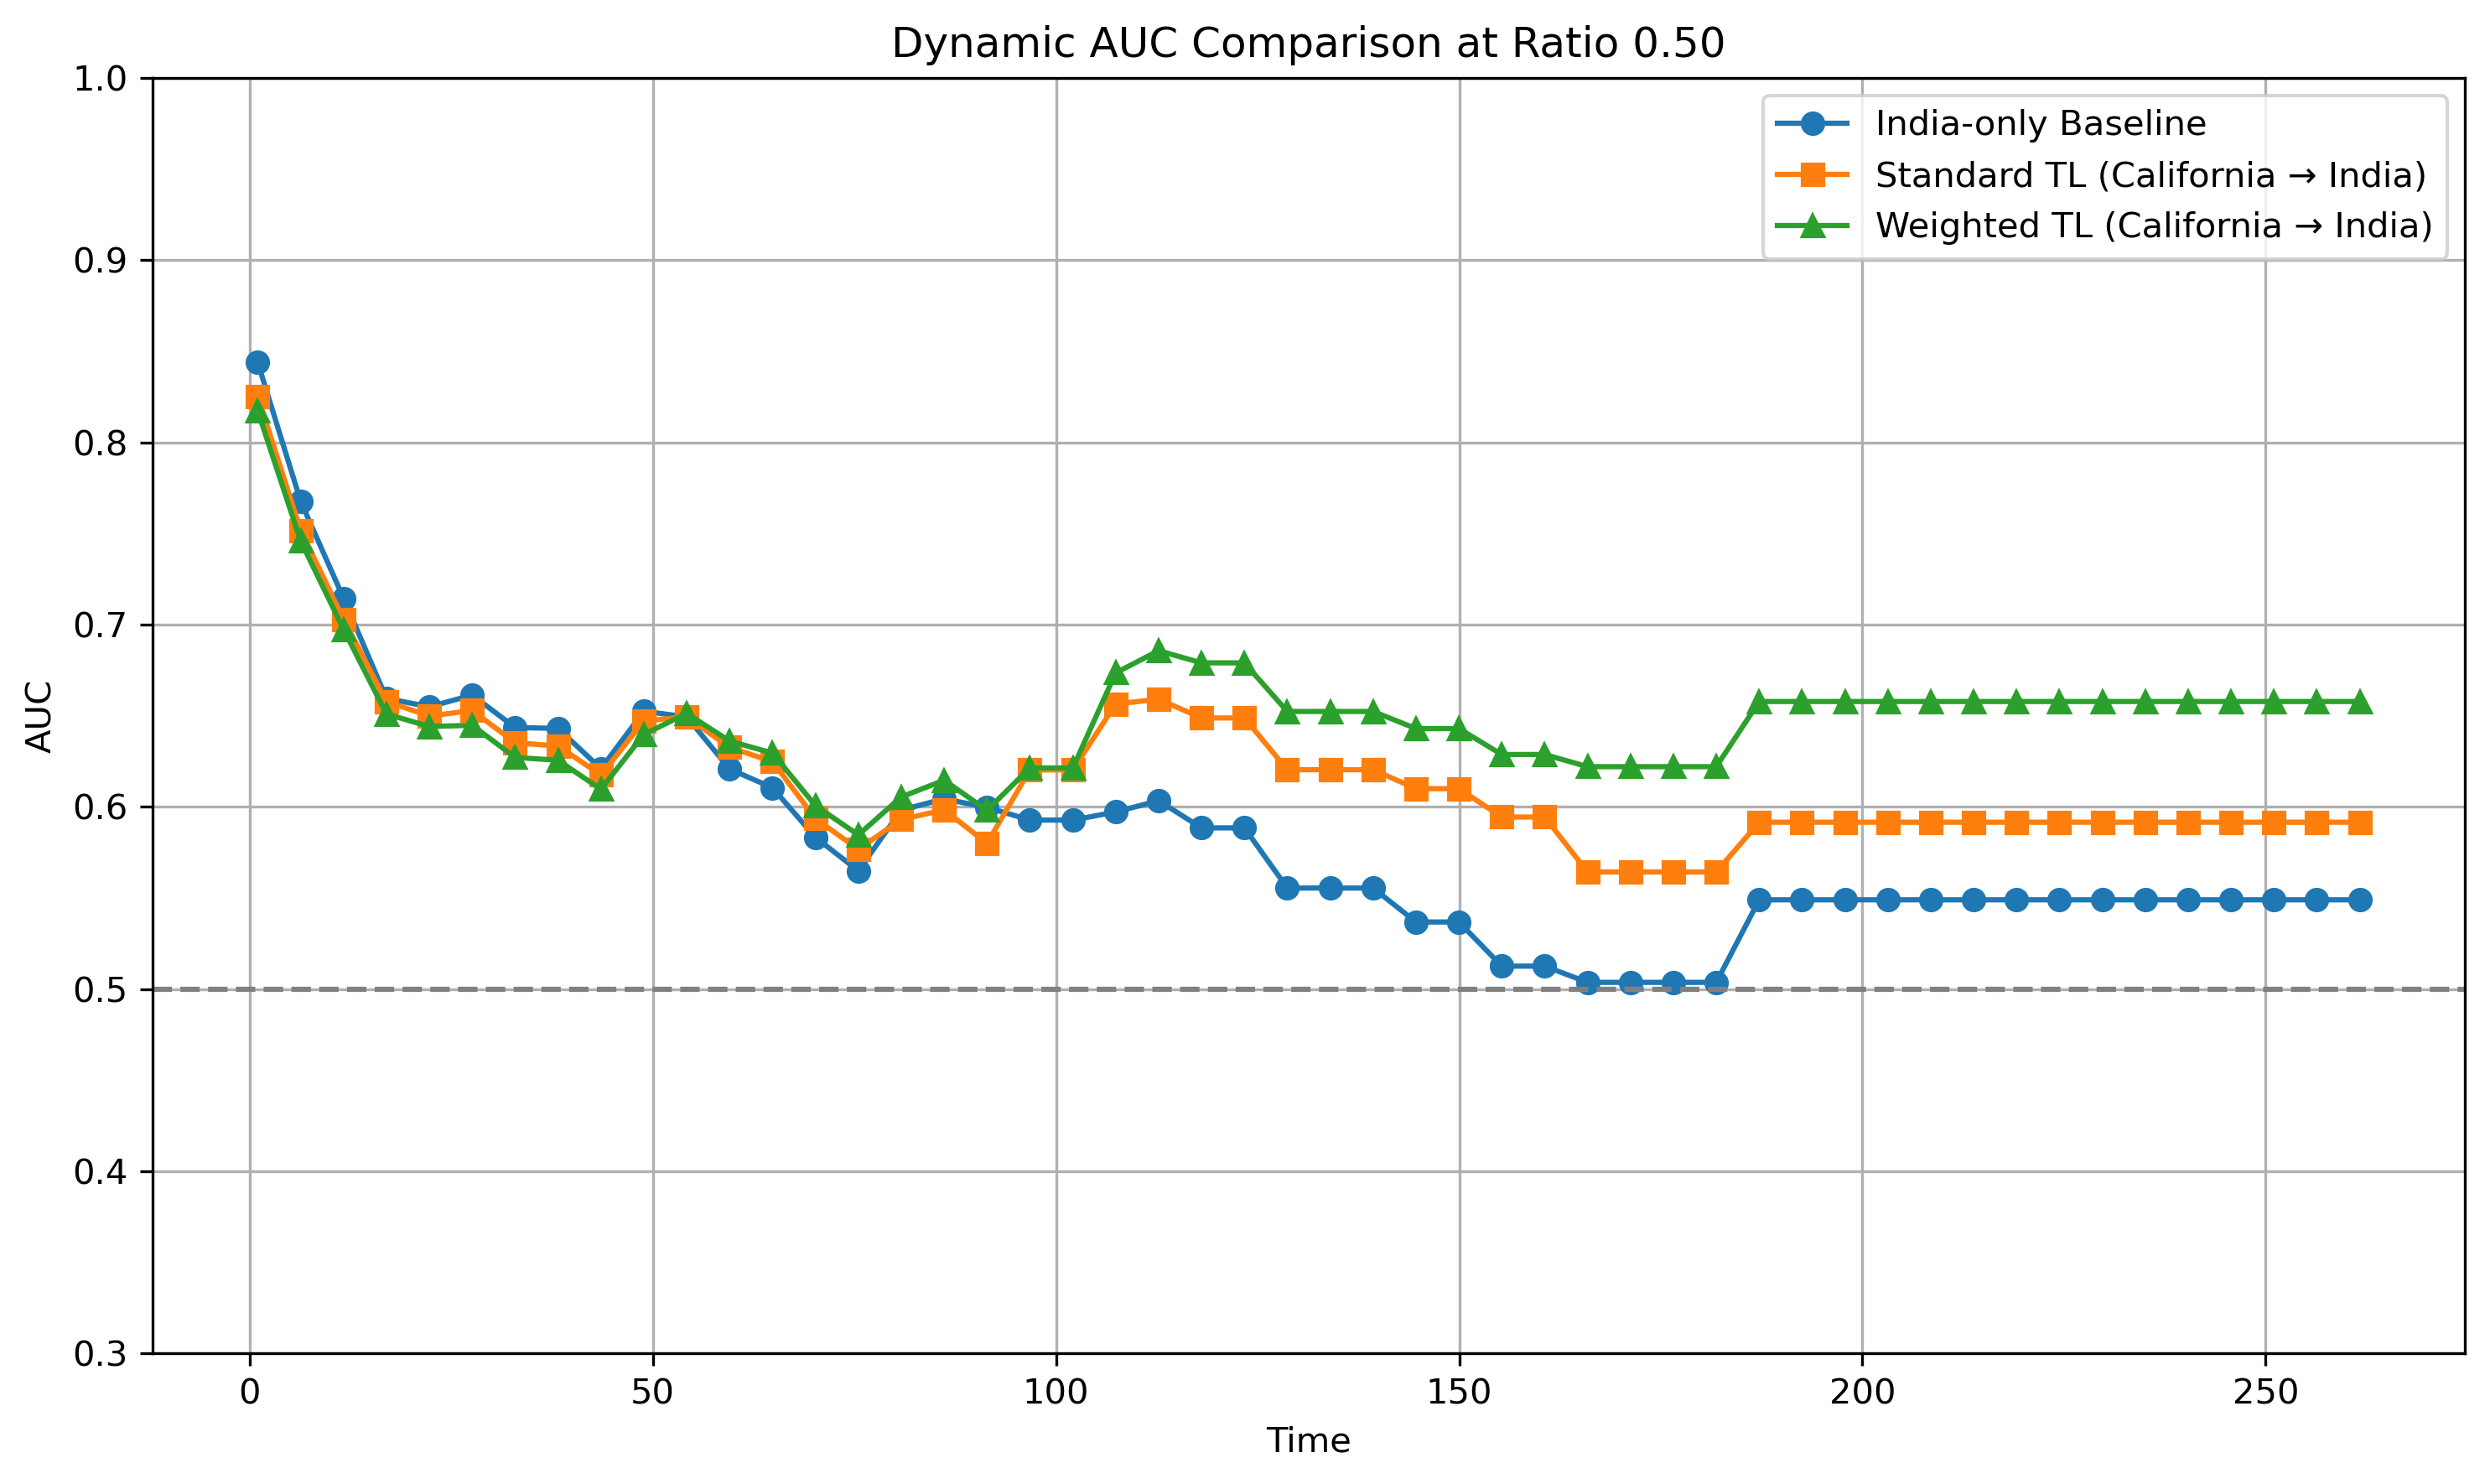

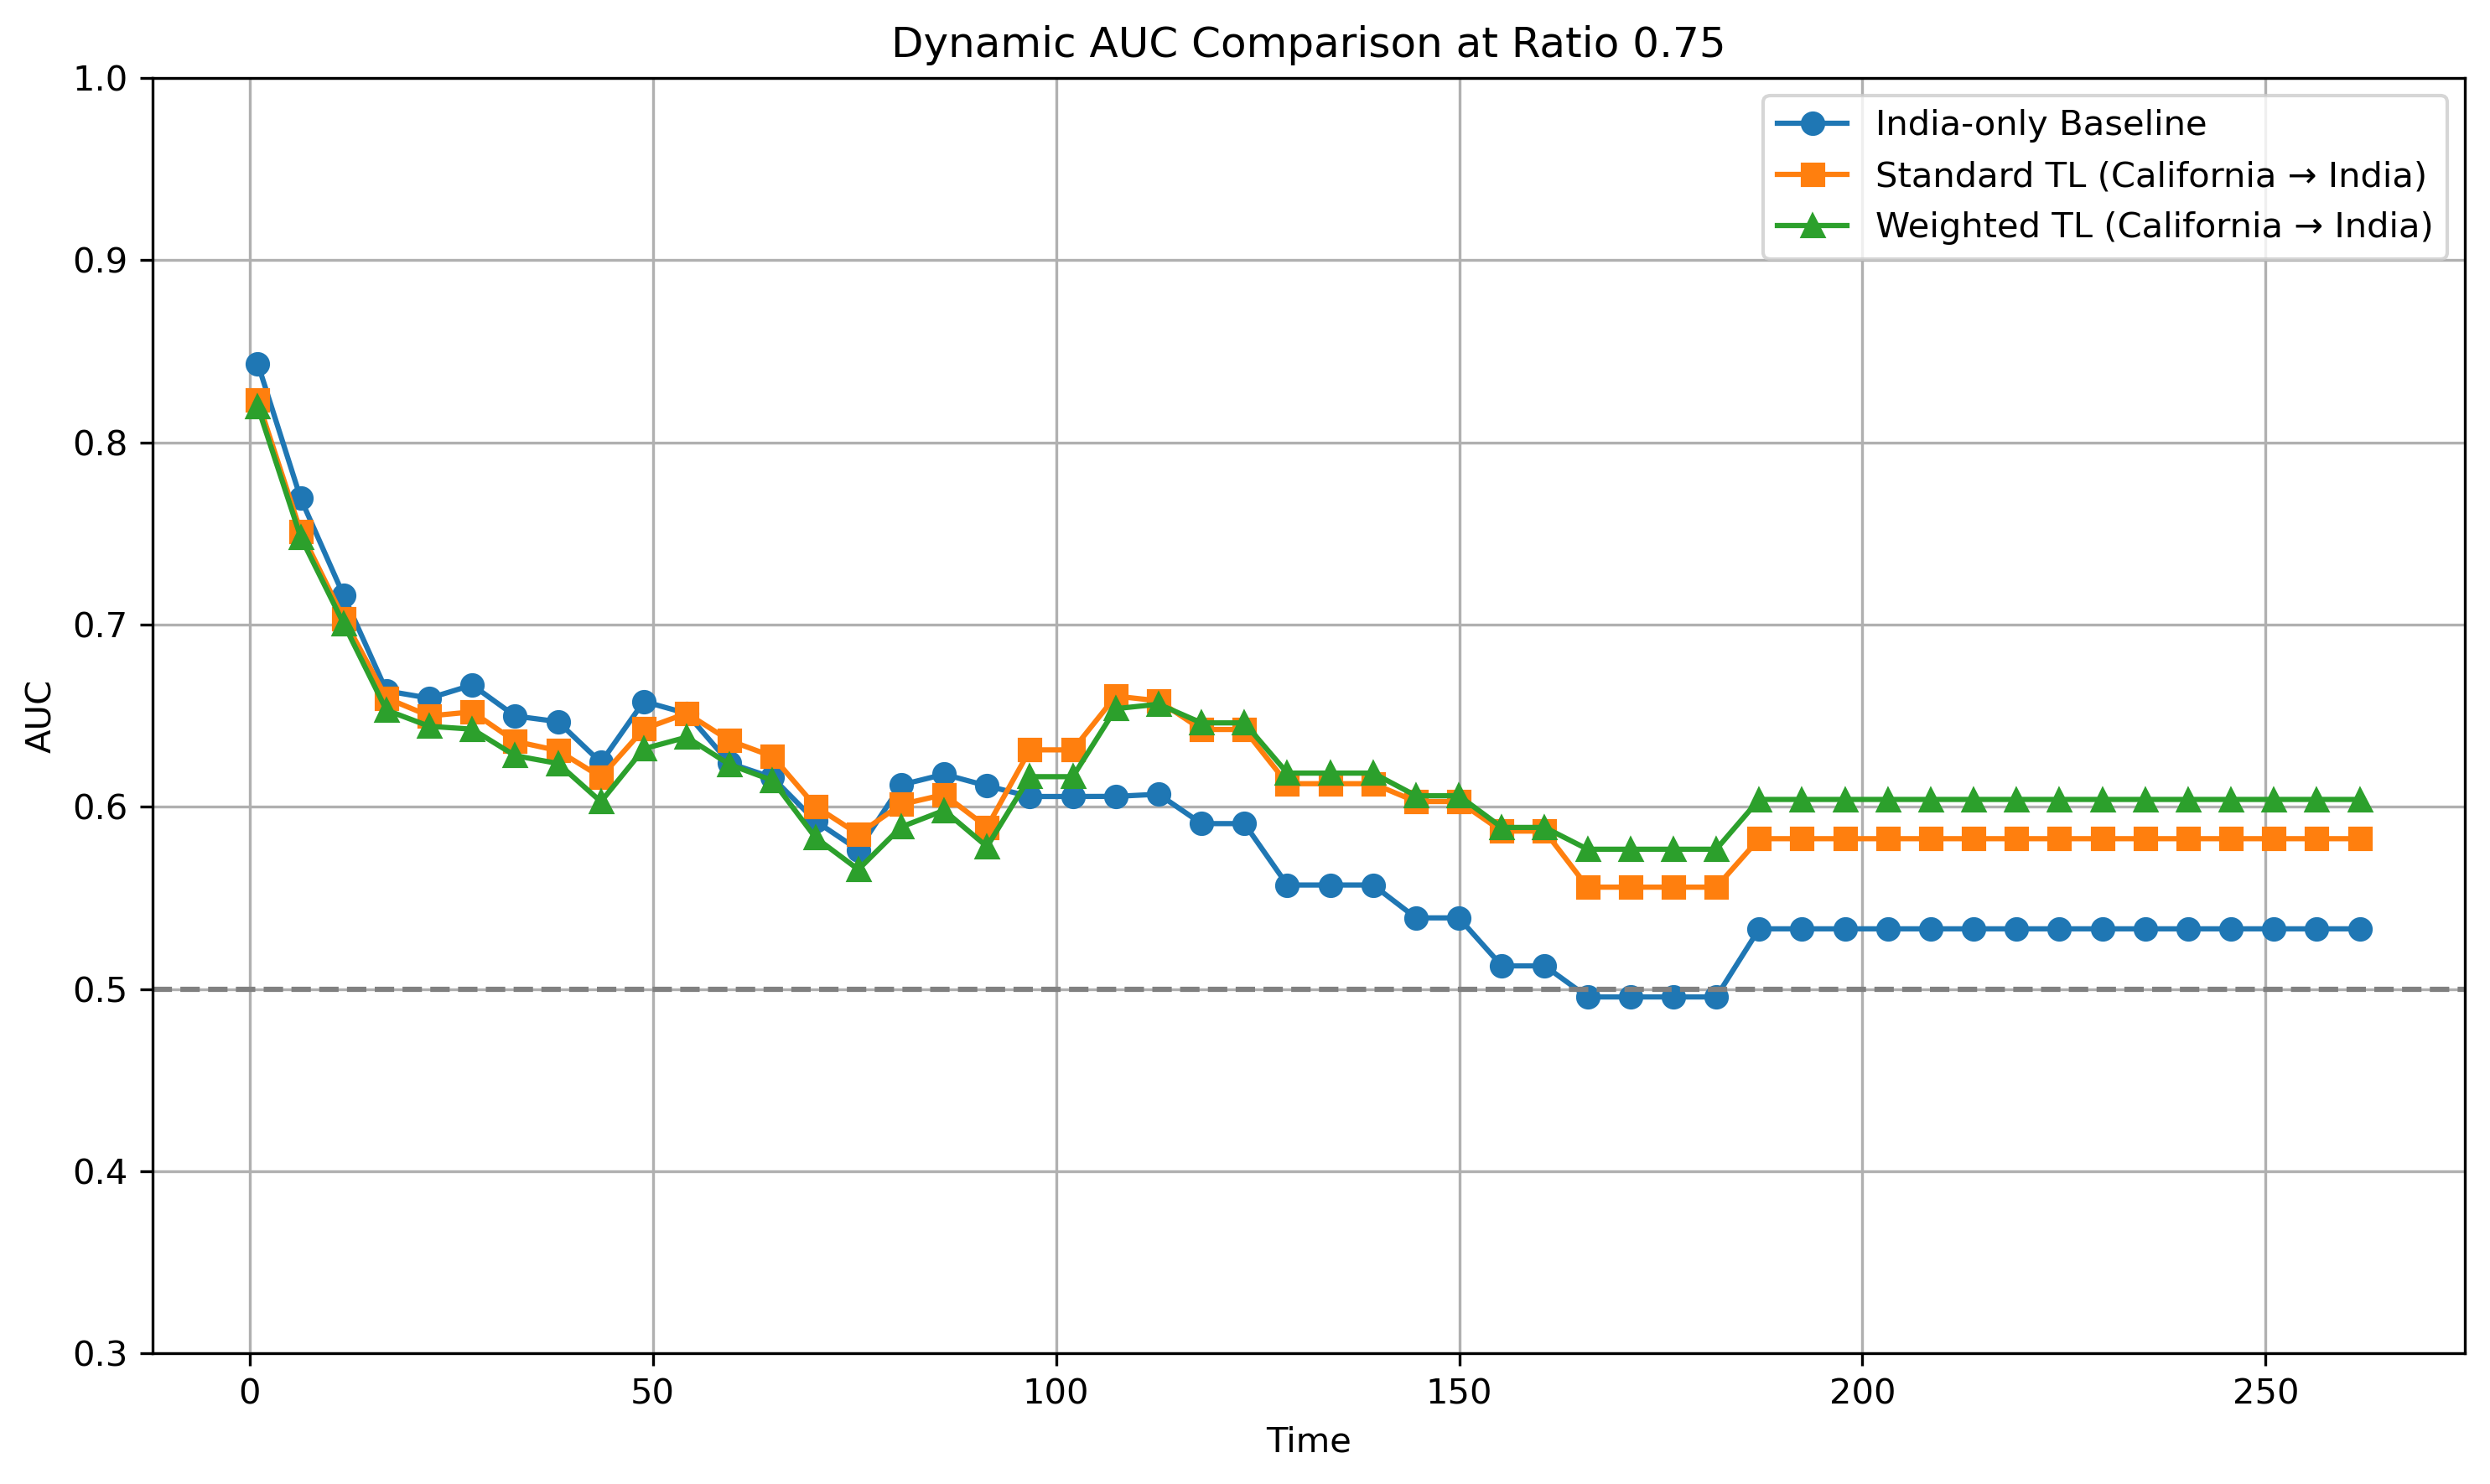

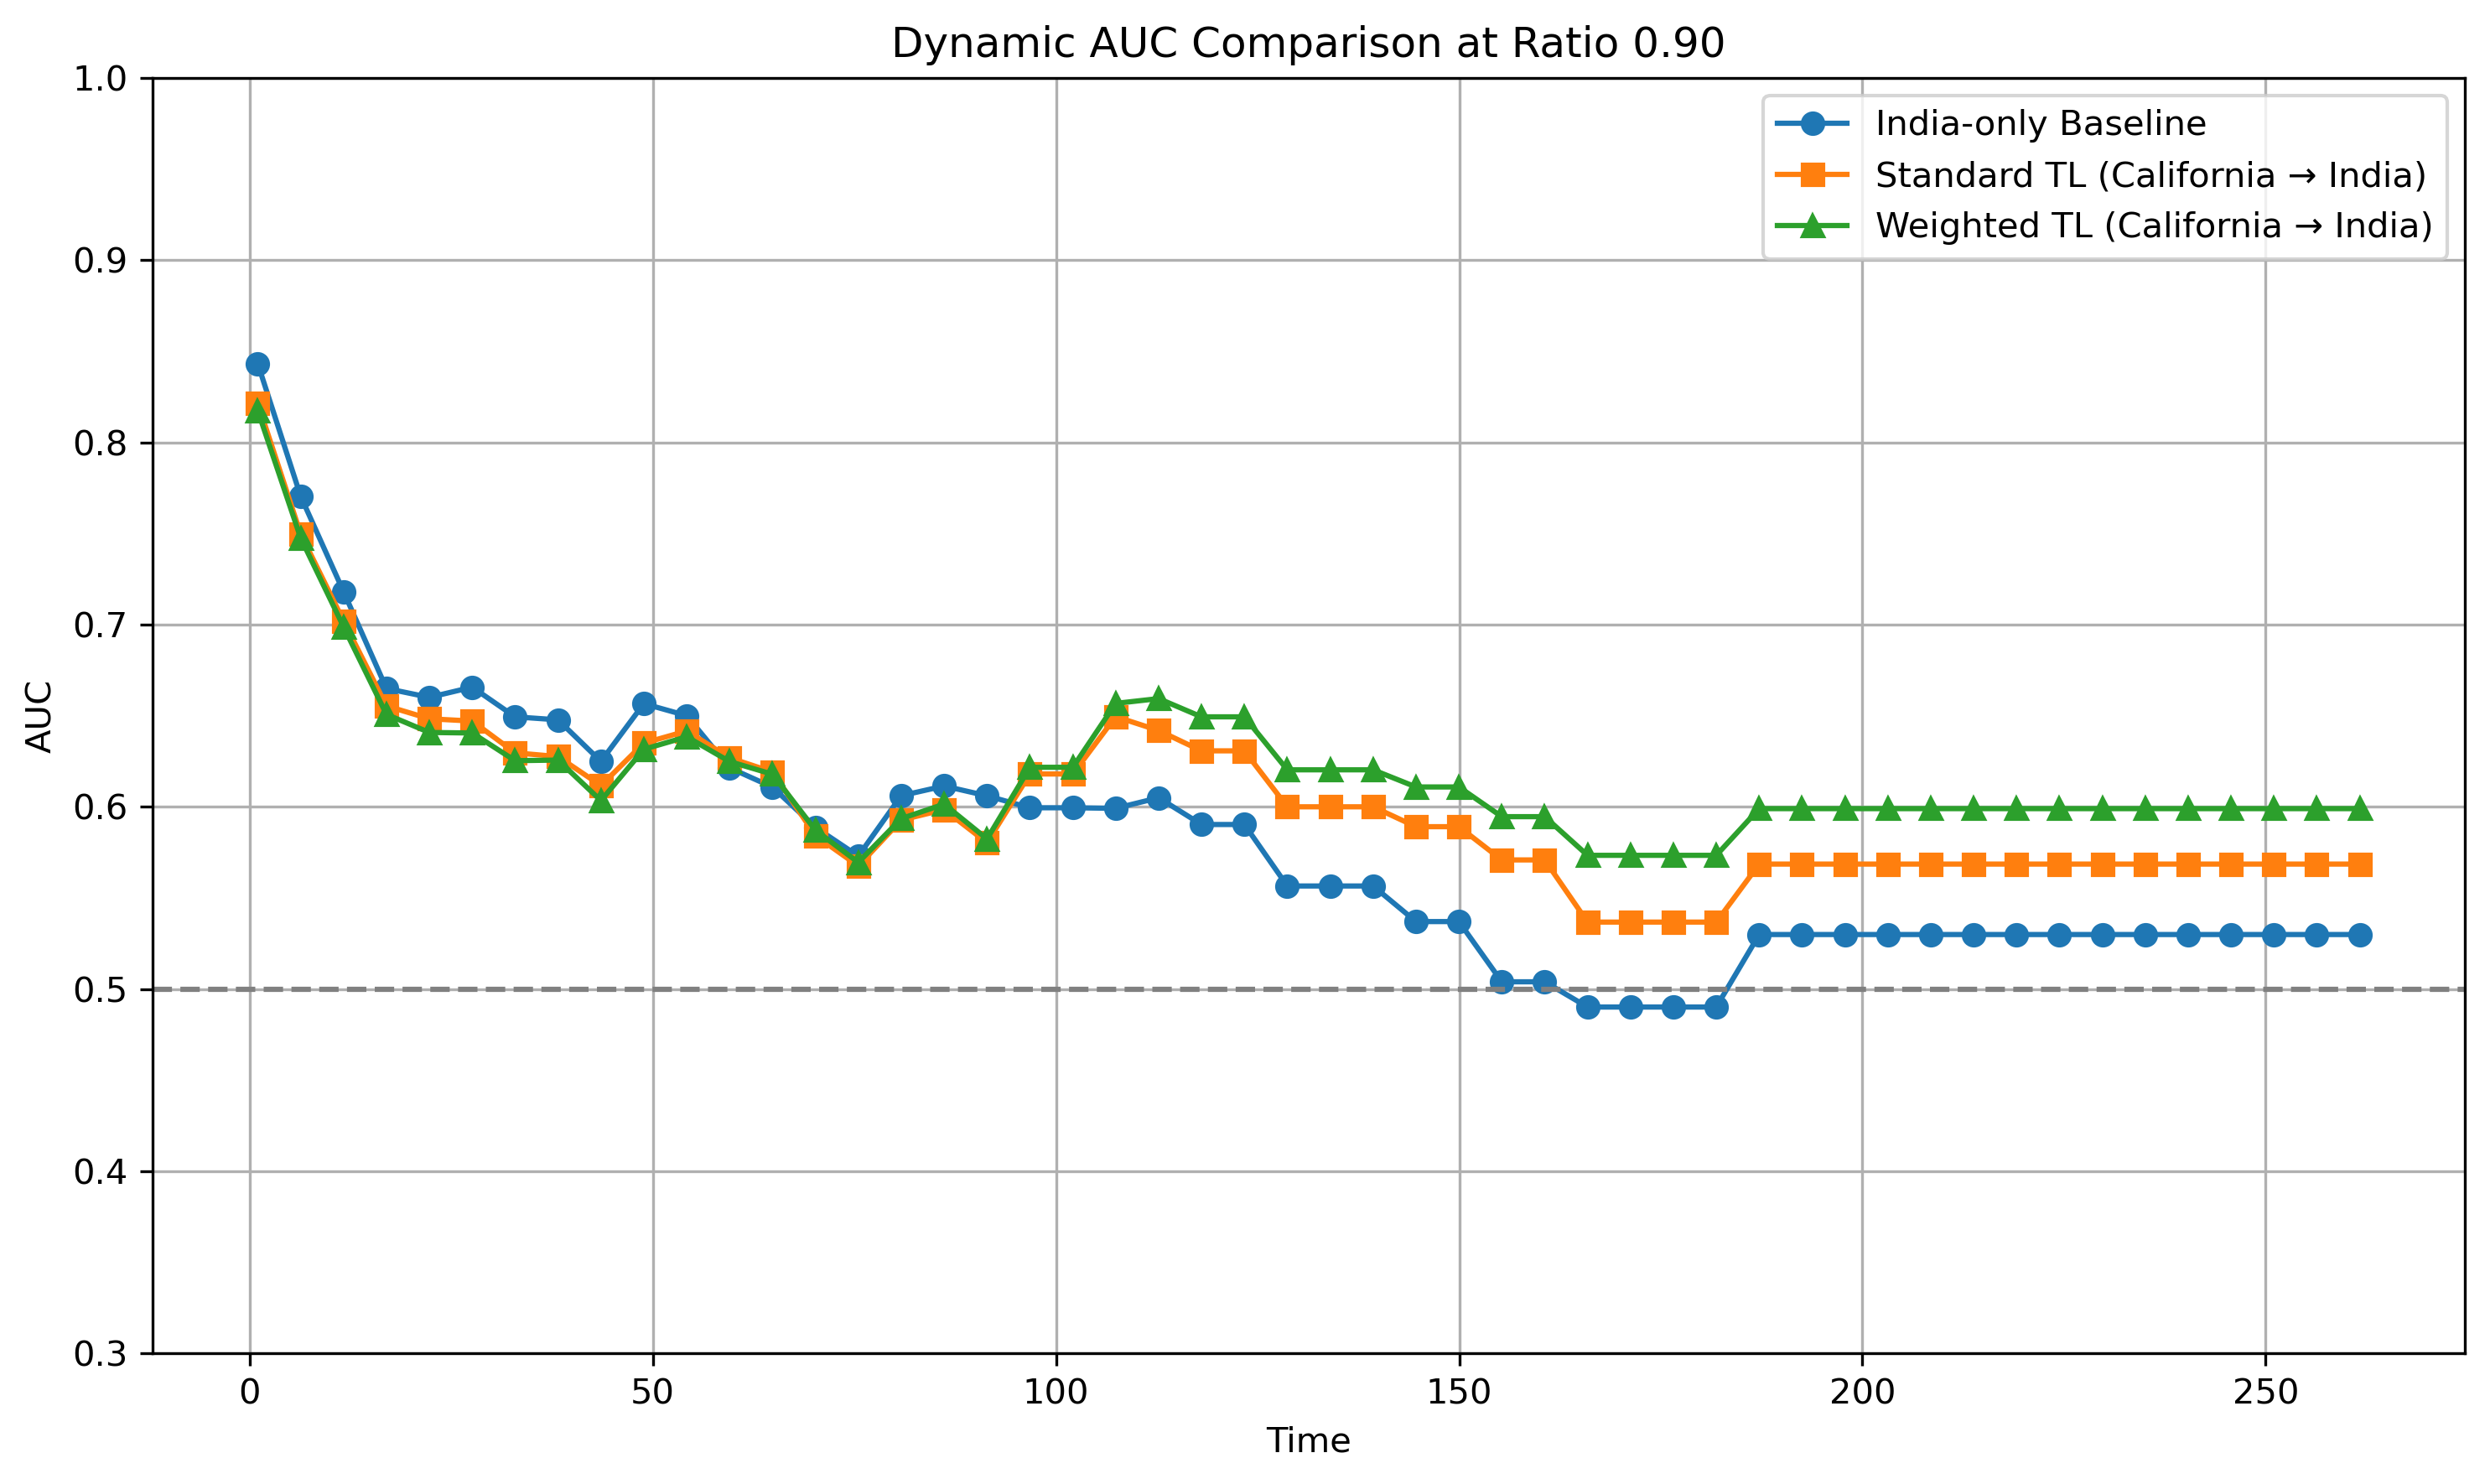

,Train_Ratio,Approach,AUC
0,0.05,Baseline,0.575302
1,0.05,Standard TL,0.604442
2,0.05,Weighted TL,0.614220
3,0.10,Baseline,0.551714
4,0.10,Standard TL,0.584846
5,0.10,Weighted TL,0.584720
6,0.25,Baseline,0.582716
7,0.25,Standard TL,0.605542
8,0.25,Weighted TL,0.624489
9,0.50,Baseline,0.585354


In [32]:
import numpy as np
import matplotlib.pyplot as plt
from sksurv.metrics import cumulative_dynamic_auc
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.utils import compute_sample_weight

# --- Pre-split target train/test
X_target = to_X(target_df)
y_target = to_sksurv_y(target_df)
X_source = to_X(source_df)
y_source = to_sksurv_y(source_df)

X_train_full, X_test, y_train_full, y_test = train_test_split(
    X_target, y_target, test_size=0.2, random_state=42
)
y_events = y_train_full["event"].astype(int)

# --- Dynamic AUC time grid
min_time = y_test["time"].min()
max_time = y_test["time"].max()
eval_times = np.linspace(min_time, max_time - 1e-6, num=50)

# --- Function to compute dynamic AUC curve
def compute_dynamic_auc_v(y_train, y_test, risk, time_points):
    auc_curve = []
    for t in time_points:
        _, auc = cumulative_dynamic_auc(y_train, y_test, risk, times=t)
        auc_curve.append(auc)
    return np.array(auc_curve)

# --- Few-shot ratios and results container
ratios = [0.05, 0.10, 0.25, 0.50, 0.75, 0.90]
results = []

for ratio in ratios:
    sss = StratifiedShuffleSplit(n_splits=1, train_size=ratio, random_state=42)
    train_idx, _ = next(sss.split(X_train_full, y_events))
    X_fewshot = X_train_full[train_idx]
    y_fewshot = y_train_full[train_idx]

    # --- Baseline model
    model_baseline = GradientBoostingSurvivalAnalysis(n_estimators=100, random_state=42)
    model_baseline.fit(X_fewshot, y_fewshot)
    pred_baseline = model_baseline.predict(X_target)

    # --- Standard Transfer
    model_transfer = GradientBoostingSurvivalAnalysis(n_estimators=100, warm_start=True, random_state=42)
    model_transfer.fit(X_source, y_source)
    model_transfer.set_params(n_estimators=150)
    model_transfer.fit(X_fewshot, y_fewshot)
    pred_transfer = model_transfer.predict(X_target)

    # --- Weighted Transfer
    model_transfer_w = GradientBoostingSurvivalAnalysis(n_estimators=100, warm_start=True, random_state=42)
    model_transfer_w.fit(X_source, y_source)
    model_transfer_w.set_params(n_estimators=150)
    sample_weight = compute_sample_weight(class_weight={1: 5, 0: 1}, y=y_fewshot["event"].astype(int))
    model_transfer_w.fit(X_fewshot, y_fewshot, sample_weight=sample_weight)
    pred_transfer_w = model_transfer_w.predict(X_target)

    # --- Compute Dynamic AUC curves
    auc_base = compute_dynamic_auc_v(y_target, y_target, pred_baseline, time_points=eval_times)
    auc_trans = compute_dynamic_auc_v(y_target, y_target, pred_transfer, time_points=eval_times)
    auc_weighted = compute_dynamic_auc_v(y_target, y_target, pred_transfer_w, time_points=eval_times)

    # --- Store mean AUC
    results.append({
        "Train_Ratio": ratio,
        "Approach": "Baseline",
        "AUC": np.mean(auc_base)
    })
    results.append({
        "Train_Ratio": ratio,
        "Approach": "Standard TL",
        "AUC": np.mean(auc_trans)
    })
    results.append({
        "Train_Ratio": ratio,
        "Approach": "Weighted TL",
        "AUC": np.mean(auc_weighted)
    })

    # --- Plot
    plt.figure(figsize=(10, 6), dpi=300)
    plt.plot(eval_times, auc_base, label=f"{target_name}-only Baseline", marker='o')
    plt.plot(eval_times, auc_trans, label=f"Standard TL ({source_name} → {target_name})", marker='s')
    plt.plot(eval_times, auc_weighted, label=f"Weighted TL ({source_name} → {target_name})", marker='^')

    plt.axhline(0.5, ls='--', color='gray')
    plt.title(f'Dynamic AUC Comparison at Ratio {ratio:.2f}')
    plt.xlabel('Time')
    plt.ylabel('AUC')
    plt.ylim(0.3, 1.0)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Save results
results_df = pd.DataFrame(results)
results_df

